In [74]:
from datetime import datetime
from ta import add_all_ta_features
import pandas as pd
import requests
import math
import numpy as np
import time
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
import matplotlib.pyplot as plt
from statistics import mean

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

AV_KEY='5AK7ZPDAGCNO39B7'

In [2]:
STOCKS = ['500.PAR'] # ['500.PAR','IBM']
CRYPTOS = ['BTC','ETH']
LABEL_SYMBOL = '500.PAR'
DIFFS = {1:3, 5:3, 20:3}
LABEL = 'close'
LOOK_AHEAD = ['open']
NAN_LIMIT = 100 #remove 
NO_SAMPLES = 500
TRAINING_RATIO = 0.5

In [3]:
TECHNICAL_COLS = ['volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']

In [72]:
class Predictor:
    def __init__(self, threshold, leverage, exit_method, models, pred_method = 'ave', capture_thresh = 0.01):
        self.exit_method = exit_method
        self.threshold = threshold
        self.leverage = leverage # percent of the base pal is multiplied by this, leverage = 1 / margin_req
        self.models = models
        self.pred_method = pred_method
        self.capture_thresh = capture_thresh
        
    def get_agg_prediction(self, index, prediction_dict):
        preds = []
        for model in self.models:
            mod_preds = prediction_dict[model]
            preds.append(prediction_dict[model].iloc[index]['prediction'])
        if self.pred_method == 'ave':
            return mean(preds)
    
    def expected_perc_pal(self, prediction, open):
        return abs((prediction - open) / open) * self.leverage
    
    def bet_made(self, prediction, open):
        if self.expected_perc_pal(prediction, open) > self.threshold:
            return True
        return False
                       
    def bet_dir(self, prediction, open):
        if self.bet_made(prediction, open):
            return int((prediction - open) / abs(prediction - open))
        return 0
    
    def exit_at(self, prediction, open, close, high, low):
        if self.exit_method == 'at_close':
            return close
        elif self.exit_method == 'at_pred_or_close':
            if prediction < open and low <= prediction:
                return prediction
            elif prediction > open and high >= prediction:
                return prediction
            else:
                return close
        elif self.exit_method == 'capture_gains':
            if prediction < open and low <= open - open * self.capture_thresh:
                return open - open * self.capture_thresh
            elif prediction > open and high >= open + open * self.capture_thresh:
                return open + open * self.capture_thresh
            else:
                return close
            
    def percent_pal(self, prediction, open, close, high, low):
        if self.bet_made(prediction, open):
            bet_dir = self.bet_dir(prediction, open)
            exit_price = self.exit_at(prediction, open, close, high, low)
            return (exit_price - open) / open * bet_dir * self.leverage
        return 0

def GetStockPriceDF(symbol): 
    cols = ['open', 'high', 'low', 'close', 'volume']
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+symbol+'&outputsize=full&apikey='+AV_KEY
    print(url)
    try:
        r = requests.get(url)
        data = r.json()
        dic = data['Time Series (Daily)']
        df = pd.DataFrame.from_dict(dic, orient='index')
        df = df[['1. open', '2. high', '3. low', '4. close', '6. volume']]
        df = df.rename(columns={'1. open': 'open', '2. high': 'high', '3. low': 'low','4. close':'close', '6. volume':'volume'})
        df.index.name = 'date'
        df = df.sort_index(ascending = True)
        df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
        return df
    except Exception as e: print(e)
    return None

def GetCryptoPriceDF(symbol): 
    cols = ['open', 'high', 'low', 'close', 'volume']
    url = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol='+symbol+'&market=CNY&apikey='+AV_KEY
    print(url)
    r = requests.get(url)
    data = r.json()
    dic = data['Time Series (Digital Currency Daily)']
    df = pd.DataFrame.from_dict(dic, orient='index')
    df = df[['1a. open (CNY)', '2a. high (CNY)', '3a. low (CNY)', '4a. close (CNY)', '5. volume']]
    df = df.rename(columns={'1a. open (CNY)': 'open', '2a. high (CNY)': 'high', '3a. low (CNY)': 'low', '4a. close (CNY)': 'close', '5. volume':'volume'})
    df.index.name = 'date'
    df = df.sort_index(ascending = True)
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    return df

def CalculateTechnicals(df, technical_cols):
    cols = ['open', 'high', 'low', 'close', 'volume']
    technicals = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume")
    technicals = technicals[technical_cols]
    return technicals

def SampleDataframe(df, date, no_samples):
    ind = df.index.get_loc(date)
    if ind-no_samples > 0:
        df = df.iloc[ind+1-no_samples:ind+1,:]
        return df
    return None

def DiffShift(df, columns, diffs):
    final_dfs = []
    for diff in diffs.keys():
        diff_df = pd.DataFrame()   
        for col in columns:
            if diff == 0:
                diff_df[col] = df[col]
            else:
                diff_df[col+'_D'+str(diff)] = df[col].rolling(window=diff+1).apply(lambda x: x.iloc[diff] - x.iloc[0])
        sampled_dfs = []
        for shift in diffs[diff]:
            sampled_df = diff_df.shift(periods=shift)
            sampled_df = sampled_df.add_suffix('_S'+str(shift))
            sampled_dfs.append(sampled_df)
        final_df = pd.concat(sampled_dfs, axis=1, join="inner")
        final_dfs.append(final_df)   
    pivot_df = pd.concat(final_dfs, axis=1, join="inner")
    return pivot_df

def CreateDataset(stocks, pivot_cols, pivots, peak_cols, technical_cols, label_symbol, label_col):
    full_res, label_df, base_prices = [], None, None
    for symbol in stocks: 
        time.sleep(5)
        sym_dfs = []
        df = GetStockPriceDF(symbol)

        #print(df)
        sym_dfs.append(DiffShift(df, pivot_cols, pivots)) # pivot
        sym_dfs.append(DiffShift(df, peak_cols, {1:[0]})) # peak ahead
        technicals = CalculateTechnicals(df, technical_cols) # calculate technicals
        #print(technicals)
        sym_dfs.append(DiffShift(technicals, technical_cols, {0:[1]})) #shifted technicals
        sym_df = pd.concat(sym_dfs, axis=1, join="inner").add_prefix(symbol + '_') #combined symbol data
        full_res.append(sym_df)
        
        if symbol == label_symbol:
            label_df = DiffShift(df, [label_col], {1:[0]})
            base_prices = df[['open','high','low','close']]
            
    full_res.append(label_df)
    res_df = pd.concat(full_res, axis=1, join='inner')
    base_prices = base_prices[base_prices.index.isin(res_df.index)]
    return res_df, base_prices

# sklearn models
def Reverse_Scale(scaler, y, data_width):
    holder = np.zeros((y.shape[0], data_width))
    holder[:,-1] = y
    holder = scaler.inverse_transform(holder)
    return holder[:,-1]

def TrainForDate(sampled_df, test_size, model, param_grid, pca_comps, no_its):
    data = sampled_df.to_numpy()

    scaler = StandardScaler()
    scl_data = scaler.fit_transform(data)
    x, y = scl_data[:,:-1], scl_data[:,-1]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

    #fit pca on train, transform test
    pca = PCA(n_components=pca_comps)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)
    
    print('pca variance: ' + str(sum(pca.explained_variance_ratio_)))

    clf = GridSearchCV(model, param_grid, refit=True, scoring='neg_root_mean_squared_error')
    best_model = clf.fit(x_train, y_train) # model.fit(x_train,y_train)
    y_train_pred = best_model.predict(x_train)
    y_test_pred = best_model.predict(x_test)

    mse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    mse_test = mean_squared_error(y_test, y_test_pred, squared=False)
              
    #y_train_pred = best_model.predict(x_train)
    #y_test_pred = best_model.predict(x_test)
    #y_test_pred_oscale = Reverse_Scale(scaler, y_test_pred, data.shape[1])
    #y_test_acts_oscale = Reverse_Scale(scaler, y_test, data.shape[1])
    #plt.plot(y_test_pred_oscale, label = "predictions")
    #plt.plot(y_test_acts_oscale, label = "actual")
    #plt.show()
    
    y_train_pred = best_model.predict(x_train)
    y_test_pred = best_model.predict(x_test)
    y_test_pred_oscale = Reverse_Scale(scaler, y_test_pred, data.shape[1])
    y_test_acts_oscale = Reverse_Scale(scaler, y_test, data.shape[1])
    best_mse_oscale = mean_squared_error(y_test_acts_oscale, y_test_pred_oscale, squared=False)
    print('Params: ' + str(best_model.best_params_))
    PlotPredVsAct(y_test_pred_oscale, y_test_acts_oscale, 'mse: ' + str(best_mse_oscale))
    
    return scaler, pca, best_model, best_mse_oscale
    
def PlotPredVsAct(pred, acts, title):
    plt.figure(figsize=(7, 2))
    plt.plot(pred, label = "predictions")
    plt.plot(acts, label = "actual")
    plt.legend(loc="upper left")
    
    plt.title(title)
    plt.show()
    
def PredictForDate(df, prev_price, date, scaler, pca, model):
    sampled_df = SampleDataframe(df, date, 1)
    data = sampled_df.to_numpy()
    scl_data = scaler.transform(data)
    x, y = scl_data[:,:-1], scl_data[:,-1]
    x = pca.transform(x)
    y_pred = model.predict(x)
    y_pred_oscale = Reverse_Scale(scaler, y_pred, data.shape[1])
    return prev_price + y_pred_oscale[0]

def GenerateModelResults(df, base_prices, model_param_sets, pca_comps, no_its, no_samples, test_size, regression_range):
    model_sets_results = {}
    for key in model_param_sets:
        model_param_set = model_param_sets[key]
        res_dict = {'date':[], 'open':[], 'close':[], 'prediction':[], 'test_mse':[]}
        for i in regression_range:
            date = df.index[i]
            prev_date = df.index[i-1]
            open = base_prices.iloc[i]['open']
            close = base_prices.iloc[i]['close']

            sampled_df = SampleDataframe(df, prev_date, no_samples)
            scaler, pca, model, test_MSE = TrainForDate(sampled_df, test_size, model_param_set[0], model_param_set[1], pca_comps, no_its)
            prev_price = base_prices.iloc[i-1,-1]
            pred = PredictForDate(df, prev_price, date, scaler, pca, model)

            res_dict['date'].append(date)
            res_dict['open'].append(open)
            res_dict['close'].append(close)
            res_dict['prediction'].append(pred)
            res_dict['test_mse'].append(test_MSE)

        model_sets_results[key] = pd.DataFrame(res_dict)
    return model_sets_results

def GeneratePredictorResults(df, base_prices,predictors,model_sets_results, rolls=[5,10,20]):
    predictors_results = {}
    for pred_key in predictors:
        res_dict = {'date':[],'open':[], 'close':[], 'high':[], 'low':[], 'agg_prediction':[], 'expected_perc_pal':[], 'bet_made':[], 'bet_dir':[], 'exit_price':[], 'act_perc_pal':[]}
        x = 0
        for i in regression_range:
            date = df.index[i]
            open = base_prices.iloc[i]['open']
            close = base_prices.iloc[i]['close']
            high = base_prices.iloc[i]['high']
            low = base_prices.iloc[i]['low']

            predictor = predictors[pred_key]
            res_dict['date'].append(date)
            res_dict['open'].append(open)
            res_dict['close'].append(close)
            res_dict['high'].append(high)
            res_dict['low'].append(low)
            agg_pred = predictor.get_agg_prediction(x,model_sets_results)
            res_dict['agg_prediction'].append(agg_pred)
            res_dict['expected_perc_pal'].append(predictor.expected_perc_pal(agg_pred,open))
            res_dict['bet_made'].append(predictor.bet_made(agg_pred,open))
            res_dict['bet_dir'].append(predictor.bet_dir(agg_pred,open))
            res_dict['exit_price'].append(predictor.exit_at(agg_pred, open, close, high, low))
            res_dict['act_perc_pal'].append(predictor.percent_pal(agg_pred, open, close, high, low))
            x+=1

        metrics = pd.DataFrame(res_dict)
        for roll in rolls:
            metrics[str(roll) + 'D_mean'] = metrics['act_perc_pal'].rolling(roll).mean()
            metrics[str(roll) + 'D_cumprod'] = (1 + metrics['act_perc_pal']).rolling(roll).apply(np.prod, raw=True) - 1
        predictors_results[pred_key] = metrics
    return predictors_results

def PlotPredictorResults(PredictorName, PredictorResults):
    fig, axs = plt.subplots(2,2, figsize=(12,6))
    axs[0, 0].set_title('rolling means')
    axs[0, 1].set_title('cumulative prods')
    
    for roll in [5,10,20]:
        mean_data = PredictorResults[str(roll) + 'D_mean'].dropna()
        sns.lineplot(data = PredictorResults, x = 'date', y = str(roll) + 'D_mean' , ax=axs[1,0])
        sns.kdeplot(mean_data,bw=0.25,ax=axs[0,0])

        cump_data = PredictorResults[str(roll) + 'D_cumprod'].dropna()
        sns.lineplot(data = PredictorResults, x = 'date', y = str(roll) + 'D_cumprod' , ax=axs[1,1])
        sns.kdeplot(cump_data,bw=0.25,ax=axs[0,1])
        
        if roll == 20:
            print(PredictorName + ', average 20D mean: ' + str(mean_data.mean()) + ', average 20 cumprod: ' + str(cump_data.mean()))
    plt.show()

In [75]:
stocks = ['500.PAR','NDAQ','DAX','AAPL','MSFT','AMZN','FB']
pivot_cols = ['open'] # ['open','high','low','close','volume']
pivots = {1:[1,2,3,4,5,6,7,8,9,10],10:[10,20,30]}

peak_cols = ['open']
technical_cols = TECHNICAL_COLS #['volume_adi']

label_symbol = '500.PAR'
label_col = 'close'

df, base_prices = CreateDataset(stocks, pivot_cols, pivots, peak_cols, technical_cols, label_symbol, label_col) 

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=500.PAR&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NDAQ&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=DAX&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=AAPL&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=AMZN&outputsize=full&apikey=5AK7ZPDAGCNO39B7
https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=FB&outputsize=full&apikey=5AK7ZPDAGCNO39B7


In [76]:
print(len(df.index))
print(len(base_prices.index))
base_prices.tail()

1779
1779


,open,high,low,close
date,,,,
2021-11-29,77.5338,77.7581,77.1450,77.5660
2021-11-30,76.6506,76.9988,76.1206,76.5517
2021-12-01,76.5126,77.3519,76.4900,77.2558
2021-12-02,75.5645,76.0569,74.8931,75.8087
2021-12-03,76.4030,76.7012,75.4624,75.6945


In [77]:
df.tail()

,500.PAR_open_D1_S1,500.PAR_open_D1_S2,500.PAR_open_D1_S3,500.PAR_open_D1_S4,500.PAR_open_D1_S5,500.PAR_open_D1_S6,500.PAR_open_D1_S7,500.PAR_open_D1_S8,500.PAR_open_D1_S9,500.PAR_open_D1_S10,...,FB_momentum_ao_S1,FB_momentum_kama_S1,FB_momentum_roc_S1,FB_momentum_ppo_S1,FB_momentum_ppo_signal_S1,FB_momentum_ppo_hist_S1,FB_others_dr_S1,FB_others_dlr_S1,FB_others_cr_S1,close_D1_S0
date,,,,,,,,,,,,,,,,,,,,,
2021-11-29,-1.8116,0.6551,0.3054,-0.4997,0.3594,0.3111,-0.2367,0.8224,0.4484,0.5202,...,7.505796,336.190858,-0.670901,-10.029623,-5.992582,-4.037041,-2.328036,-2.355563,771.316548,1.1400
2021-11-30,0.1694,-1.8116,0.6551,0.3054,-0.4997,0.3594,0.3111,-0.2367,0.8224,0.4484,...,5.606164,336.209719,3.171163,-10.559320,-6.905929,-3.653390,1.473943,1.463186,784.159260,-1.0143
2021-12-01,-0.8832,0.1694,-1.8116,0.6551,0.3054,-0.4997,0.3594,0.3111,-0.2367,0.8224,...,1.838958,334.981963,-1.000793,-7.359993,-6.996742,-0.363251,-4.014437,-4.097239,748.665247,0.7041
2021-12-02,-0.1380,-0.8832,0.1694,-1.8116,0.6551,0.3054,-0.4997,0.3594,0.3111,-0.2367,...,-1.441591,331.576743,-8.885564,-2.959908,-6.189375,3.229467,-4.271713,-4.365635,712.412704,-1.4471
2021-12-03,-0.9481,-0.1380,-0.8832,0.1694,-1.8116,0.6551,0.3054,-0.4997,0.3594,0.3111,...,-6.193826,328.766339,-10.694556,-1.768123,-5.305125,3.537002,-0.067611,-0.067634,711.863423,-0.1142


In [79]:
sampled_df = SampleDataframe(df, '2021-11-24', 300)
for col in sampled_df.columns:
    if sampled_df[col].isnull().values.any():
        print(col)
        print(sampled_df[col].isnull().values)

pca variance: 0.9999999999999999
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


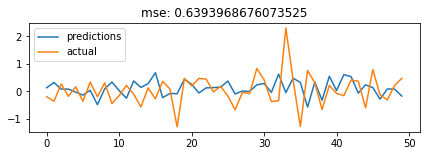

pca variance: 1.0000000000000004
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


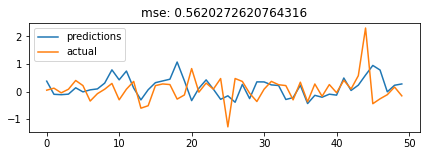

pca variance: 0.9999999999999998
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


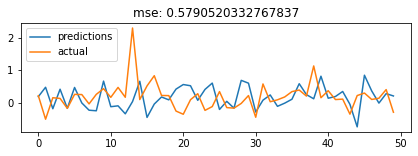

pca variance: 0.9999999999999999
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


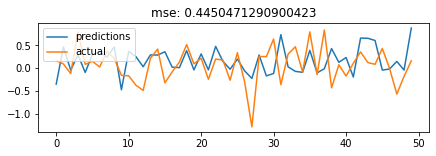

pca variance: 1.0000000000000002
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


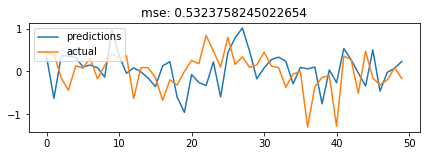

pca variance: 1.0000000000000002
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


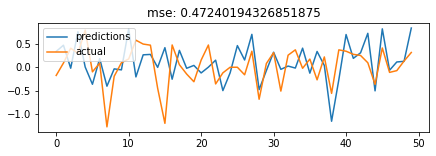

pca variance: 1.0000000000000004
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


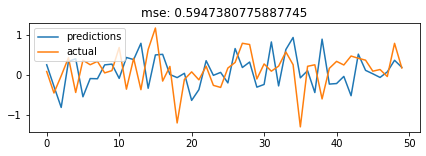

pca variance: 0.9999999999999997
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


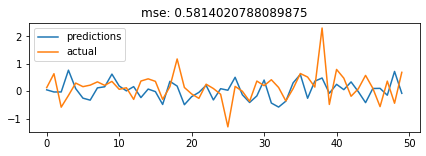

pca variance: 0.9999999999999989
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


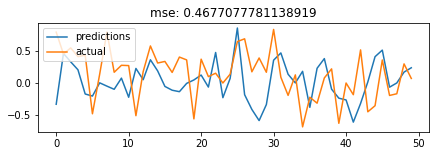

pca variance: 1.0000000000000004
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


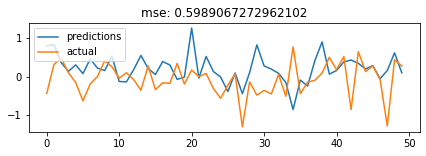

pca variance: 1.0000000000000002
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


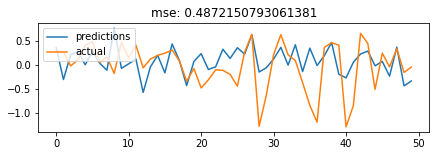

pca variance: 0.9999999999999997
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


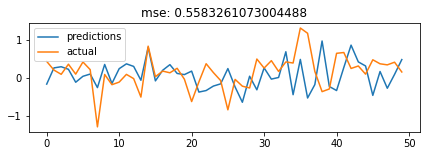

pca variance: 1.0000000000000002
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


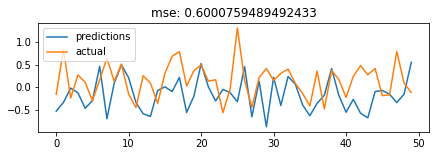

pca variance: 1.0000000000000002
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


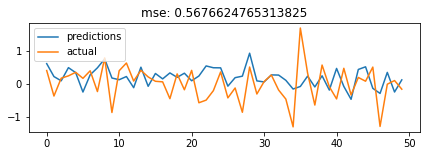

pca variance: 0.9999999999999999
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


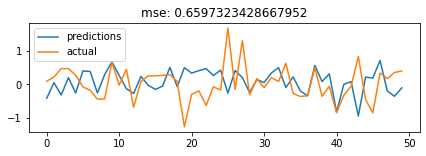

pca variance: 1.0000000000000007
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


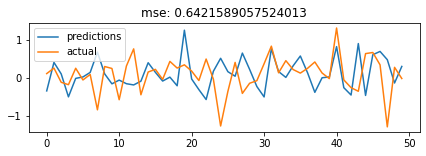

pca variance: 1.0
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


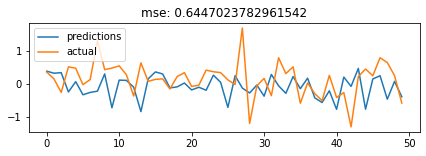

pca variance: 0.9999999999999999
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


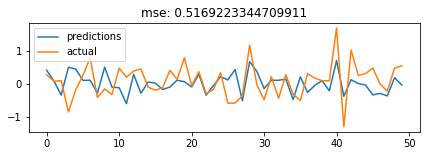

pca variance: 0.9999999999999998
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


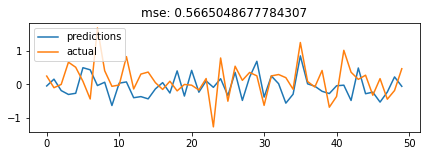

pca variance: 0.9999999999999993
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


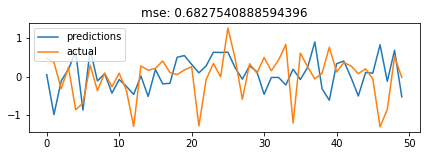

pca variance: 0.9999999999999996
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


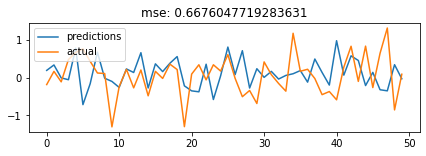

pca variance: 0.9999999999999996
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


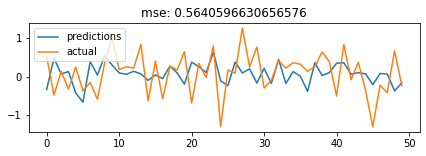

pca variance: 0.9999999999999994
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


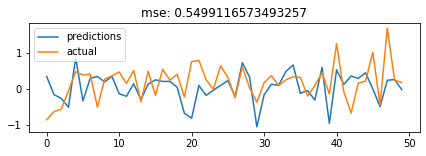

pca variance: 0.9999999999999998
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


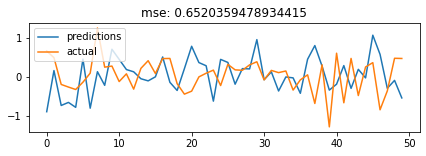

pca variance: 1.0000000000000002
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


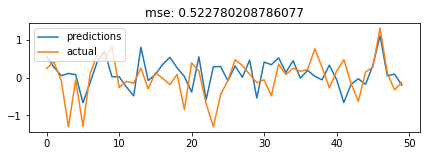

pca variance: 1.0000000000000002
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


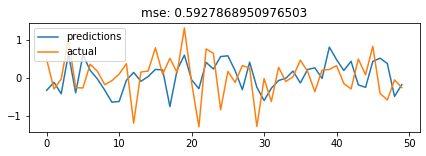

pca variance: 0.9999999999999997
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


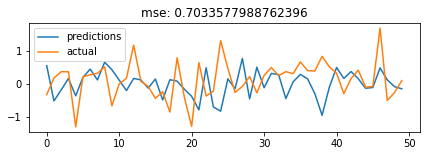

pca variance: 1.0000000000000002
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


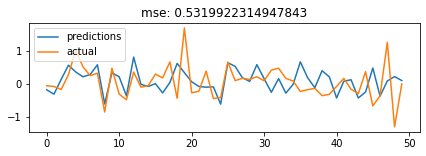

pca variance: 0.9999999999999999
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


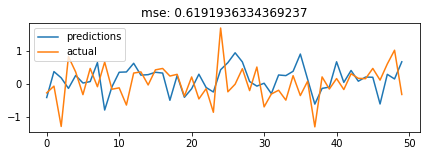

pca variance: 1.0
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


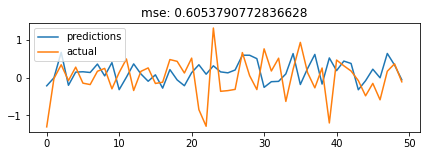

pca variance: 0.9999999999999999
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


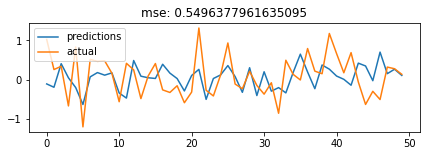

pca variance: 0.9999999999999997
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


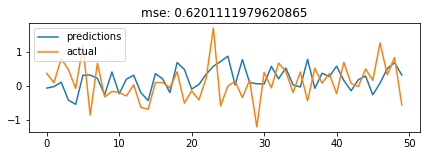

pca variance: 0.9999999999999999
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


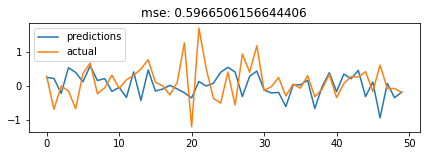

pca variance: 1.0000000000000007
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


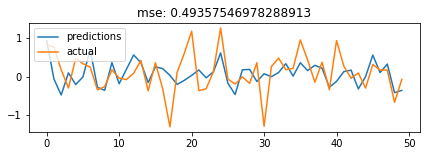

pca variance: 0.9999999999999998
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


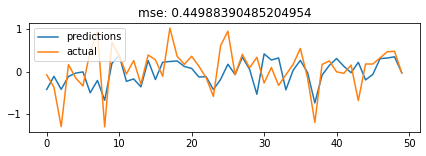

pca variance: 0.9999999999999999
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


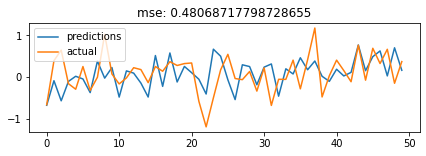

pca variance: 0.9999999999999997
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


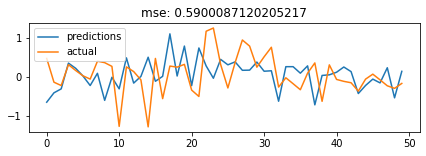

pca variance: 1.0000000000000002
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


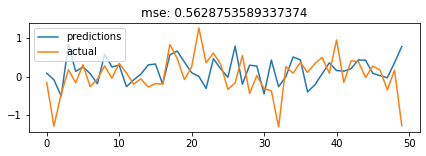

pca variance: 0.9999999999999992
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


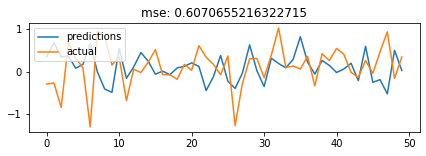

pca variance: 1.0
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


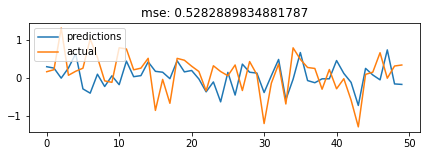

pca variance: 0.9999999999999996
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


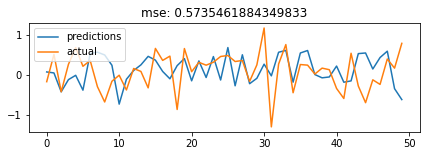

pca variance: 1.0000000000000004
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


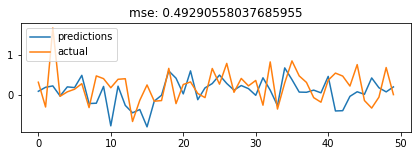

pca variance: 0.9999999999999994
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


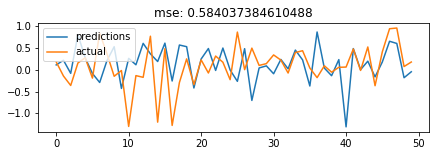

pca variance: 0.9999999999999998
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


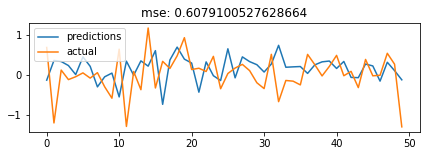

pca variance: 1.0000000000000002
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


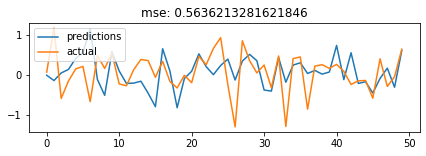

pca variance: 1.0
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


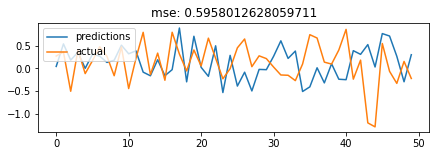

pca variance: 0.9999999999999998
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


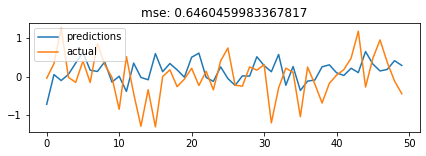

pca variance: 0.9999999999999993
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


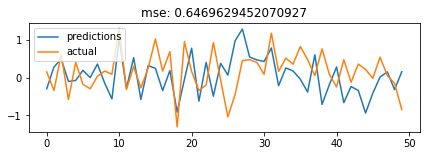

pca variance: 1.0
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


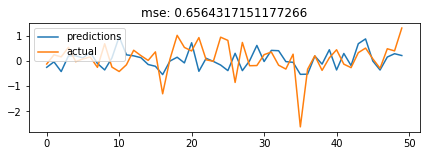

pca variance: 1.0000000000000002
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


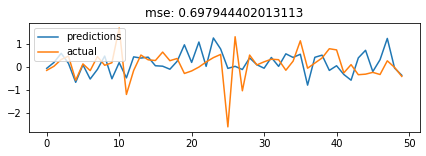

In [97]:
#model training parameters
regression_range = range(len(df.index)-50,len(df.index))

pca_comps = 100
no_samples = 150
test_size = 0.33

model_param_sets = {'M1': (MLPRegressor(random_state=42), 
                           {'hidden_layer_sizes':[(56,28)], 'max_iter':[100,200,300], 'activation':['relu'], 'solver':['adam'], 'learning_rate_init':[0.001]})} #,
#model_sets = {'M1': [SGDRegressor(max_iter=2000, tol=1e-3)]}

model_sets_results = GenerateModelResults(df, base_prices, model_param_sets, pca_comps, no_its, no_samples, test_size, regression_range)

In [82]:
model_sets_results['M1']

,date,open,close,prediction,test_mse
0,2021-09-24,71.0340,71.2590,71.410520,0.515041
1,2021-09-27,71.8365,71.4339,71.442273,0.574496
2,2021-09-28,71.2725,70.1350,71.488332,0.537194
3,2021-09-29,70.3569,70.7824,70.154214,0.459761
4,2021-09-30,71.1540,70.5600,70.319787,0.520096
5,2021-10-01,69.3260,70.1157,70.706584,0.673481
6,2021-10-04,70.1465,69.2680,69.939230,0.616165
7,2021-10-05,69.7227,70.5850,68.850716,0.487107
8,2021-10-06,70.0788,70.1720,70.967691,0.633278
9,2021-10-07,71.2665,71.8690,69.987806,0.569439


sell at close, average 20D mean: 0.006594522721609759, average 20 cumprod: 0.1347291537849558


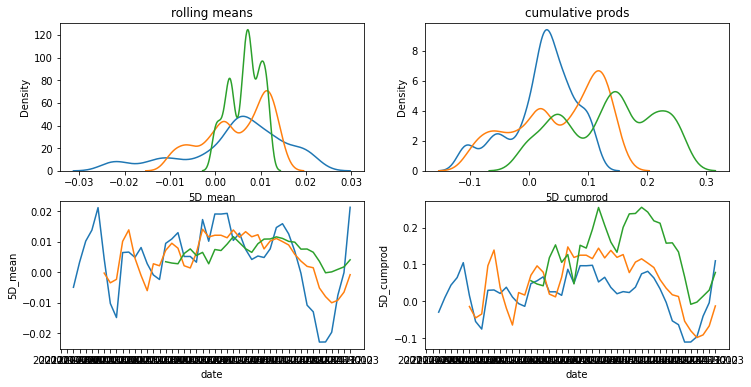

sell at pred or close, average 20D mean: 0.002659733580421369, average 20 cumprod: 0.053026845810780154


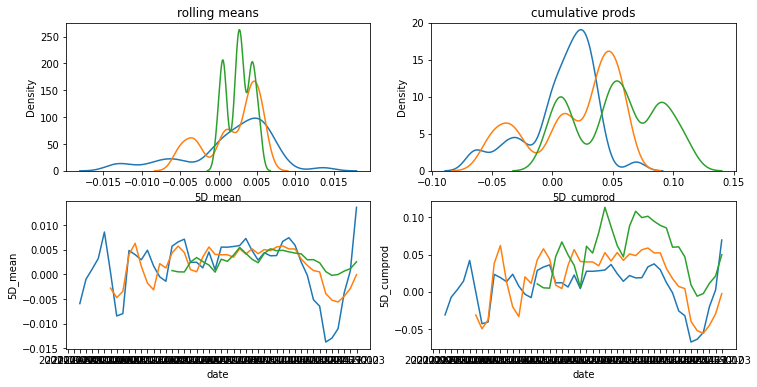

capture gains, average 20D mean: 0.0036418617570854795, average 20 cumprod: 0.07356378228441057


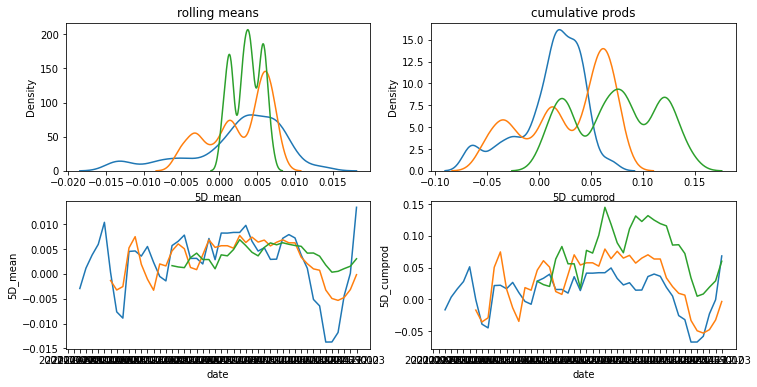

In [98]:
predictors = {'sell at close': Predictor(threshold=0.005, leverage=5, exit_method='at_close', models=['M1'], pred_method='ave'),
             'sell at pred or close': Predictor(threshold=0.005, leverage=3, exit_method='at_pred_or_close', models=['M1'], pred_method='ave'),
             'capture gains': Predictor(threshold=0.005, leverage=3, exit_method='capture_gains', models=['M1'], pred_method='ave', capture_thresh = 0.01)}

predictor_results = GeneratePredictorResults(df, base_prices, predictors, model_sets_results)
x = [PlotPredictorResults(x, predictor_results[x]) for x in predictor_results]

In [69]:
predictor_results['sell at close']

,date,open,close,high,low,agg_prediction,expected_perc_pal,bet_made,bet_dir,exit_price,act_perc_pal,5D_mean,5D_cumprod,10D_mean,10D_cumprod,20D_mean,20D_cumprod
0,2021-10-08,71.7390,71.5075,71.7800,71.3970,72.061598,0.022484,True,1,71.5075,-0.016135,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-11,71.0699,71.6314,71.6715,71.0000,71.043239,0.001876,False,0,71.6314,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-10-12,70.4148,71.0449,71.1998,70.4000,71.621261,0.085668,True,1,71.0449,0.044742,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-10-13,70.6458,70.5409,70.9581,70.4289,71.381776,0.052089,True,1,70.5409,-0.007424,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-10-14,71.0780,71.8020,71.8265,71.0000,70.528469,0.038657,True,-1,71.8020,-0.050930,-0.005949,-0.031708,NaN,NaN,NaN,NaN
5,2021-10-15,72.0413,72.4134,72.5000,72.0328,72.511171,0.032611,True,1,72.4134,0.025825,0.002443,0.009589,NaN,NaN,NaN,NaN
6,2021-10-18,72.3973,72.5842,72.6346,72.0375,72.374811,0.001553,False,0,72.5842,0.000000,0.002443,0.009589,NaN,NaN,NaN,NaN
7,2021-10-19,72.5241,72.9062,72.9379,72.5014,73.357007,0.057423,True,1,72.9062,0.026343,-0.001237,-0.008191,NaN,NaN,NaN,NaN
8,2021-10-20,72.9410,73.2299,73.2804,72.9410,72.719065,0.015213,True,-1,73.2299,-0.019804,-0.003713,-0.020561,NaN,NaN,NaN,NaN
9,2021-10-21,73.0330,73.1539,73.3274,73.0330,73.031905,0.000075,False,0,73.1539,0.000000,0.006473,0.031998,0.000262,-0.000724,NaN,NaN


In [163]:
predictor_results['P2']

,date,open,close,high,low,agg_prediction,expected_perc_pal,bet_made,bet_dir,exit_price,act_perc_pal,5D_mean,5D_cumprod,10D_mean,10D_cumprod,20D_mean,20D_cumprod
0,2021-10-08,48.420,48.455,48.515,48.390,47.903753,0.031986,True,-1,48.455000,-0.002169,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-11,48.475,48.595,48.695,48.465,48.499753,0.001532,False,0,48.499753,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-10-12,48.595,48.355,48.600,48.355,48.945753,0.021654,True,1,48.355000,-0.014816,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-10-13,47.915,48.035,48.180,47.910,47.865065,0.003126,False,0,48.035000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-10-14,48.280,48.365,48.500,48.260,48.341763,0.003838,False,0,48.341763,0.000000,-0.003397,-0.016953,NaN,NaN,NaN,NaN
5,2021-10-15,48.065,48.075,48.180,48.065,48.607014,0.033830,True,1,48.075000,0.000624,-0.002838,-0.014201,NaN,NaN,NaN,NaN
6,2021-10-18,48.380,48.570,48.620,48.380,48.533901,0.009543,False,0,48.533901,0.000000,-0.002838,-0.014201,NaN,NaN,NaN,NaN
7,2021-10-19,48.735,48.835,48.905,48.700,49.252063,0.031829,True,1,48.835000,0.006156,0.001356,0.006784,NaN,NaN,NaN,NaN
8,2021-10-20,49.115,48.850,49.330,48.790,49.283309,0.010280,True,1,49.283309,0.010280,0.003412,0.017134,NaN,NaN,NaN,NaN
9,2021-10-21,48.920,49.150,49.150,48.920,49.093601,0.010646,True,1,49.093601,0.010646,0.005541,0.027962,0.001072,0.010536,NaN,NaN
